# Домашняя работа 1
## В данном задании мы будем сжимать звуковую дорожку при помощи алгоритма PCA

In [ ]:
# Понадобится для чтения и записи аудио файлов
from scipy.io import wavfile

# Это нужно для проигрывания аудио файлов прямо в блокноте
from IPython.display import Audio

# А это набор для этого задания
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA

In [ ]:
# Скачаем данные
! wget https://www.dropbox.com/s/p5147nr8mzemxnr/Beethoven_Violin_Sonata_Op_96_first_movement_bars_1-22.wav

--2023-03-16 19:42:46--  https://www.dropbox.com/s/p5147nr8mzemxnr/Beethoven_Violin_Sonata_Op_96_first_movement_bars_1-22.wav
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/p5147nr8mzemxnr/Beethoven_Violin_Sonata_Op_96_first_movement_bars_1-22.wav [following]
--2023-03-16 19:42:46--  https://www.dropbox.com/s/raw/p5147nr8mzemxnr/Beethoven_Violin_Sonata_Op_96_first_movement_bars_1-22.wav
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc00c1957230cf93e3c5cc69538d.dl.dropboxusercontent.com/cd/0/inline/B4WUY5d06C3qGDE5KrFs68jj63EDSOnN1SdP4k6TNQR1aNScZb0K5ovV9qsFV8qpXbkjOV9DhqdMYFOjUOzaOc07l_tJwf48jDLHBkTXsBLwzkUns_X1uKWh6jGofSAx3UAF5vpqwJlPCE5gCdENCVMbwuWG8bMugw8wBI_akCLVew/file# [following]
--2023-03-16 19:42:47--  https://uc00c1

In [ ]:
# Прочитаем аудио дорожку при помощи wavfile
samplerate, data = wavfile.read('Beethoven_Violin_Sonata_Op_96_first_movement_bars_1-22.wav')

`samplerate` есть частота дискретизации - стандартное для аудио значние -- 44100 Гц.

NOTE: **Частота дискретизации** говорит о том, сколько последовательных элементов массива с сигналом кодируют звук длительностью 1 секунда.

Подробнее о кодировании звука [тут](https://ru.wikipedia.org/wiki/Кодирование_звуковой_информации).

In [ ]:
# Посмотрим какая у нас частота диспретезации
print(samplerate)

44100


In [ ]:
# Если поделить длину массива сигнала на samplerate, получится длительность аудиодорожки в секундах

print(len(data) / samplerate)

# 45 секунд - похоже на правду:)

45.139591836734695


In [ ]:
# Заметим, что звук - стерео, так как сигнал кодируется двумя каналами (для левого и правого динамика):

print(data.shape)

(1990656, 2)


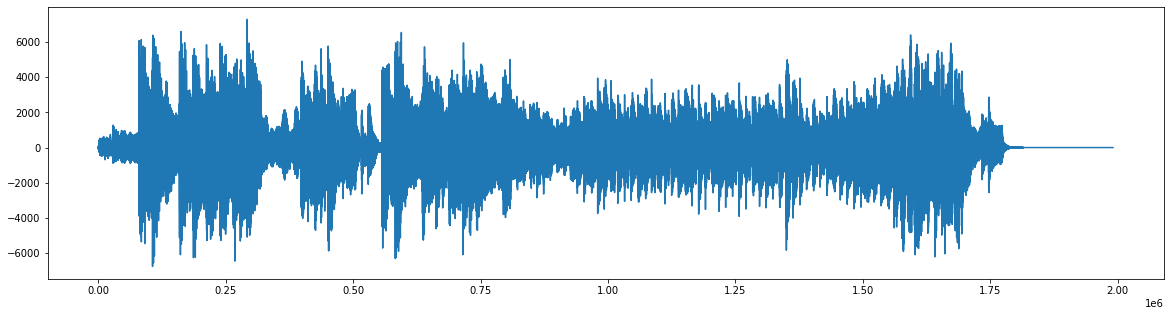

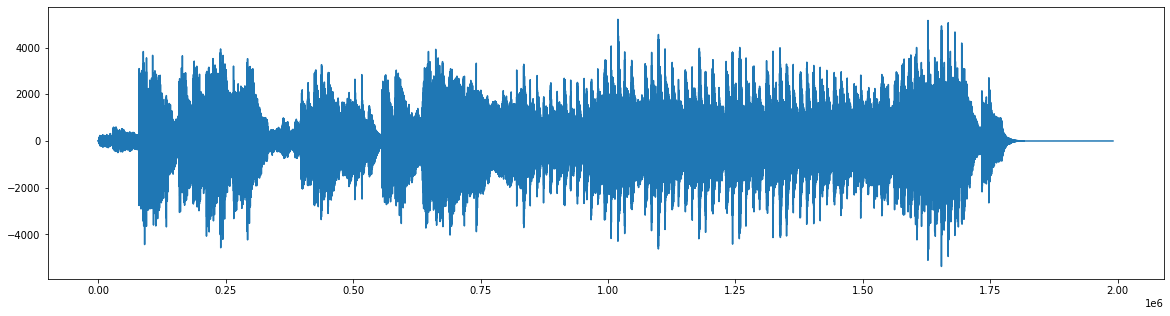

In [ ]:
# Отрисуем сигналы в обоих каналах

# Канал 1
plt.figure(figsize=(20,5))
plt.plot(data[:,0])
plt.show()

# Канал 2
plt.figure(figsize=(20,5))
plt.plot(data[:,1])
plt.show()

In [ ]:
# Усредним каналы, и получим моно звук, с которым будет проще работать

mono_sound = np.mean(data, axis=1)
print(mono_sound.shape)

(1990656,)


In [ ]:
# Давайте послушаем наконец, что же мы будем сжимать:)

Audio(mono_sound, rate = samplerate)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Для удобства - обрежем массив с сигналом так, чтобы его было удобнее делить на равные части, датасет из которых и необходимо будет сжать известными вам методами.
# На самом деле способ очень похож на тот, которым мы сжимали картинку, деля её на прямоугольные подкартинки, только здесь задача еще проще)

mono_sound_to_cut = mono_sound[:1990000]

In [ ]:
# Проверим, что наш звук теперь это просто вектор числел

print(mono_sound_to_cut.shape)

(1990000,)


#### Задание 1:

**Подсказка:** В это задании нужно всего лишь вспомнить как пользоваться методом `.reshape()`


1. Разделите сигнал на равные части (длину каждой части возьмите равной 1000) и соберите из них "датасет", который будет представлять из себя двухменый массив - "матрицу", в которой каждая часть сигнала длины 1000 находится в отдельной строке).

    То есть первая часть содержит первые 1000 чисел сигнала и находится в первой строке матрицы, вторая часть следующие 1000 чисел сигнала и находится во второй строке матрицы и так далее.

    Это также как мы делали с кусочками картинки и получали матрицу размера `(24, 1152000)`!

In [ ]:
# Ваше решение здесь
shaped = mono_sound_to_cut.reshape((int(len(mono_sound_to_cut)/1000), 1000))
shaped

array([[  0. ,  -1. ,  -1. , ...,  88.5,  58.5,  18. ],
       [-25.5, -61.5, -81.5, ...,  30.5, -20.5, -53. ],
       [-67.5, -65.5, -50. , ..., 118.5, 118.5,  86.5],
       ...,
       [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ]])

2. Напишите функцию, которая будет переводить вашу "матрицу" обратно в звуковой сигнал, то есть разворачивать данные обратно из матрицы размера `(число объектов, 1000)` в вектор длины `(число объектов * 1000)`. Проверьте, что все работает верно, путем воспроизведения "востановленного" сигнала -- он должен совпасть в точности с изначальным (ведь им на самом деле и является).

In [ ]:
# Ваше решение здесь
def restore_sound(shaped_sound):
  restored_sound = []
  for ar in shaped_sound:
    restored_sound = np.concatenate([restored_sound, ar], axis=0)
  return restored_sound



In [ ]:
restored = restore_sound(shaped)
(restored == mono_sound_to_cut).sum()

1990000

In [ ]:
Audio(restored, rate = samplerate)

Output hidden; open in https://colab.research.google.com to view.

#### Задание 2

Подсказка: код этого пункта практически полностью совпадает с кодом, который мы использовали на семинаре.

1. Выполните PCA преобразование нашей матрицы, и получите данные, сжатые в пространство меньшей размерности.

    На этом этапе у нас есть наш "датасет" с 1000 "признаками" и мы хотим уменьшить число "признаков" путем применения метода PCA. Число компонент предлагается выбрать вам, но для начала не стоит брать слишком маленькое число, чтобы потом было проще понять, в случае плохого результата -- компонент оказалось недостаточно или вы где-то ошиблись:)


In [ ]:
# Ваше решение здесь
pca_100 = PCA(n_components=100)
new_data_100 = pca_100.fit_transform(shaped)

In [ ]:
restored = pca_100.inverse_transform(new_data_100)
restored

array([[ 3.41986089e+01,  2.21238198e+01,  6.59936541e+00, ...,
         6.60184142e+01,  4.98638940e+01,  4.05896658e+01],
       [ 2.38354544e+01, -4.64739343e+00, -3.74822459e+01, ...,
         4.92555133e+01,  1.19481104e+01, -1.16488887e+01],
       [ 3.13044740e+01,  8.36402443e+00, -1.79042402e+01, ...,
         2.91725981e+01,  1.33651750e+01,  8.47762585e+00],
       ...,
       [ 1.04694293e+00,  9.53919288e-01, -2.59210117e-02, ...,
         1.09427134e+00,  1.06987299e+00,  1.17724387e+00],
       [ 1.04694293e+00,  9.53919288e-01, -2.59210117e-02, ...,
         1.09427134e+00,  1.06987299e+00,  1.17724387e+00],
       [ 1.04694293e+00,  9.53919288e-01, -2.59210117e-02, ...,
         1.09427134e+00,  1.06987299e+00,  1.17724387e+00]])

In [ ]:
shaped

array([[  0. ,  -1. ,  -1. , ...,  88.5,  58.5,  18. ],
       [-25.5, -61.5, -81.5, ...,  30.5, -20.5, -53. ],
       [-67.5, -65.5, -50. , ..., 118.5, 118.5,  86.5],
       ...,
       [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ]])


2. Постройте сами две главные компоненты в наглядной форме. Сделайте выводы исходя из их вида.

    То есть необходимо применить метод PCA к нашей матрице с числом компонент, равным 2 (тем самым получив датасет с 2 "признаками"). Это позволит нам отрисовать данные на плоскости, чтобы попытаться уловить зависимости.

In [ ]:
# Ваше решение здесь
pca_2 = PCA(n_components=2)
new_data_2 = pca_2.fit_transform(shaped)

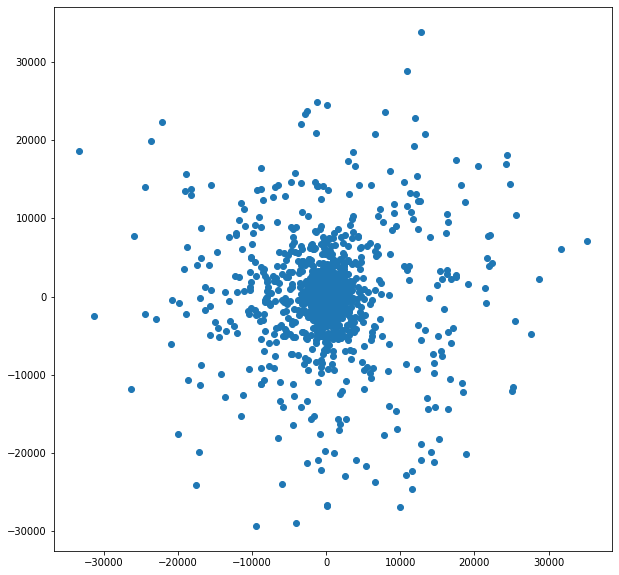

In [ ]:
fig, axes = plt.subplots(figsize=(10, 10))
axes.scatter(new_data_2[:, 0], new_data_2[:, 1])

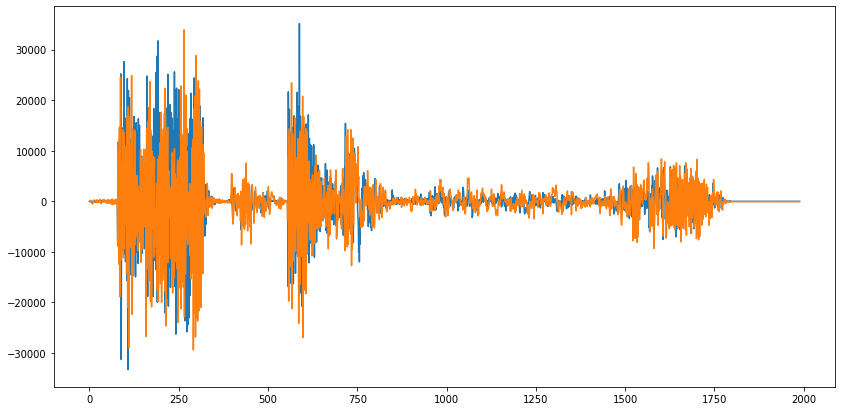

In [ ]:
fig, axes = plt.subplots(figsize=(14, 7))
axes.plot(new_data_2[:, 0])
axes.plot(new_data_2[:, 1])

3. Постройте scatter plot датасета в пространстве первых двух компонент, а третью используйте как цвет.
    То есть необходимо применить метод PCA уже с 3 компонентами и нарисовать опять точки, только передав третью компоненту в качестве цвета. (мы также делали на семинаре с картинкой)

In [ ]:
# Ваше решение здесь
pca_3 = PCA(n_components=3)
new_data_3 = pca_3.fit_transform(shaped)

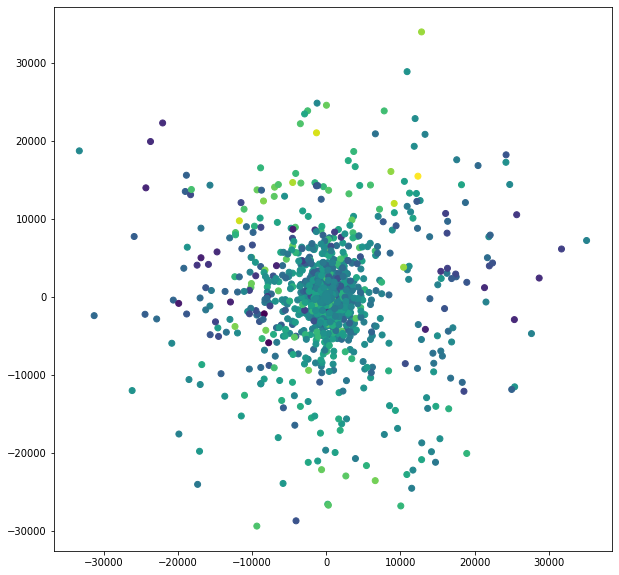

In [ ]:
fig, axes = plt.subplots(figsize=(10, 10))
axes.scatter(new_data_3[:, 0], new_data_3[:, 1], c=new_data_3[:, 2])

#### Задание 3

Нам осталось заняться непосредственно "сжатием" звука и проверкой правильности наших действий.

1. Выполните обратное PCA преобразование сжатых данных и получите "матрицу" с сжатым звуком.

    Воспользуйтесь обратным преобразованием PCA (inverse_transform), чтобы из матрицы размера `(число объектов, число компонент)` перейти в матрицу размера `(число объектов, 1000)`.

In [ ]:
# Ваше решение здесь
restored_100 = pca_100.inverse_transform(new_data_100)
restored_2 = pca_2.inverse_transform(new_data_2)
restored_3 = pca_3.inverse_transform(new_data_3)

print(restored_100.shape)
print(restored_2.shape)
print(restored_3.shape)

(1990, 1000)
(1990, 1000)
(1990, 1000)


2. Преобразуйте "матрицу", получившуюся обратным преобразованием, в сигнал (одномерный массив, наш "сжатый" монозвук), и послушайте результат `(Audio(YOUR_RESULT, rate = samplerate)`.

    Воспользуйтесь функцией, которую написали в первом задании, чтобы преобразовать матрицу с "сжатым" звуком (размер после обратного преобразования должен быть такой же, как и у оригинальной матрицы) в вектор-сигнал, который уже можно будет прослушать. Если звук похож на оригинал, то вы все сделали правильно! 

In [ ]:
# Ваше решение здесь
audio_100 = restore_sound(restored_100)
audio_2 = restore_sound(restored_2)
audio_3 = restore_sound(restored_3)

In [ ]:
Audio(audio_100, rate = samplerate)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Audio(audio_2, rate = samplerate)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Audio(audio_3, rate = samplerate)

Output hidden; open in https://colab.research.google.com to view.

3. Исследуйте зависимость качества звука от числа компонент. Подберите "на слух" минимальное число компонент, при котором звук практически не отличается от оригинала.

    Добавьте в ячейки два варианта звуковой дорожки -- оригинальную и выбранную вами. Укажите какое число компонент вы оставили.

Подсказка! попробуйте отфильтровать сигнал с помощью функции `gaussian_filter1d` из `scipy.ndimage`. Это поможет убрать неприятный дробовой шум при сильном сжатии

Пример кода для фильтрации - `Audio(gaussian_filter1d(mono_sound_compressed, 2), rate = samplerate)`

In [ ]:
# Ваше решение здесь
Audio(gaussian_filter1d(audio_100, 2), rate = samplerate)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for count in range(50, 201, 50):
  print(f"Components is {count}\n")
  pca = PCA(n_components=count)
  audio = pca.inverse_transform(pca.fit_transform(shaped))
  audio = restore_sound(audio)
  print("Without filter\n")
  display(Audio(audio, rate = samplerate))
  print("With filter\n")
  display(Audio(gaussian_filter1d(audio, 2), rate = samplerate))
  print("-"*50)


Output hidden; open in https://colab.research.google.com to view.

In [130]:
print("Original sound\n")
display(Audio(restored, rate = samplerate))
print("Sound with filter and 150 component")
pca = PCA(n_components=150)
audio = pca.inverse_transform(pca.fit_transform(shaped))
audio = restore_sound(audio)
display(Audio(gaussian_filter1d(audio, 2), rate = samplerate))

Output hidden; open in https://colab.research.google.com to view.


3.1   Ответьте на вопросы: 
- Количество компонент, которое вы выбрали это много или мало? 
- Как сильно можно сжать звук таким образом? 
- А если нам дадут другую звуковую дорожку, нам надо сделать то же самое, чтобы сжать звук, как автоматически подобрать число компонент и возможно ли это?




Выбранное количество компонент (150) - 15% от исходного количества признаков, поэтому, я считаю, что это достаточно малый объём. 

In [ ]:
# Ваше решение здесь
wavfile.write("new_sound", samplerate, pca.fit_transform(shaped))

Рамзер исходного файла примерно 8МБ, размер сжатого файла примерно 2.3МБ, то есть файл уменьшился почти в 3.5 раза

In [129]:
abs(audio - restored).mean()

15.100577105922246

In [131]:
pca = PCA(n_components=100)
audio = pca.inverse_transform(pca.fit_transform(shaped))
audio = restore_sound(audio)
abs(audio - restored).mean()

44.87868299117064

In [134]:
pca = PCA(n_components=200)
audio = pca.inverse_transform(pca.fit_transform(shaped))
audio = restore_sound(audio)
abs(audio - restored).mean()

15.115277434063078

Число компонент можно подбирать до тех пор, пока средняя абсолютная погрешность не составит 15%, начиная с некого начального значения, допустим, с 50

4. (доп задание)

  a) Оберните получившийся код по сжатию звука в одну или несколько функций

  b) Проведите исследование того, как степень сжатия (соотношения размера частей, на которые делился сигнал в задании 1.1 к размеру пространсва, в которое вы сжимали данные с помощью PCA) влияет на звук, по субъективным ощущениям. Начиная с какой степени сжания сильно слышится потеря качества? (как с учетом фильтрации с помощью gaussian_filter1d, так и без неё)

  d) Что степень сжатия означает для PCA? Для большой аудиозаписи (3 мин, например) мы хотели бы разбить на большее, меньшее или такое же число отрезков как и для предложенной аудиозаписи? Почему?

  c) Можно ли как-то автоматически подобрать степерь сжатия? За что она отвечает в нашей задаче. Как степень сжатия влияет на звук? Почему она так влияет на звук? 



In [ ]:
# Ваше решение здесь